# Kaggle Binary Classification Competition

## Setup

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
# from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

In [92]:
# output functions

## save csv to output csvs
def kaggle_output(train,file_name):
    train.to_csv(f"output_csvs/{file_name}", index = False)
    

## data prep

In [93]:
# 1. Load the dataset
train = pd.read_csv("train.csv")
kaggle_X = pd.read_csv("test.csv")

In [94]:
train.shape
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [95]:
Y = train["y"]
X = train.drop(columns = ["y","id"])

### Scaling variables

In [96]:
# Separating numerical
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays']
categorical_cols = X.drop(columns=[*numeric_cols]).columns

# Create transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline_LR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

### Data train/test split

In [97]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 17)

## Modeling

### Logistic Regression

In [98]:
pipeline_LR.fit(X, Y)
y_pred_all = pipeline_LR.predict(kaggle_X)

# Create DataFrame from predictions and assign column name
kaggle_LR_all = pd.DataFrame({"y": y_pred_all.flatten()})  

# Add the ID column from kaggle_test
kaggle_LR_all["id"] = kaggle_X["id"].values

# Reorder columns to make 'id' the first column
kaggle_LR_all = kaggle_LR_all[["id", "y"]]

# kaggle_LR_all.to_csv("LR_submission.csv", index= False)

kaggle_output(kaggle_LR_all, "LR_pred.csv")


### Random Forest

In [99]:
pipeline_RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, 
                                          class_weight='balanced',
                                          random_state=42))
])

In [100]:
# pipeline_RF.fit(X,Y) # 25ish mins

In [102]:
# RF_preds = pipeline_RF.predict(kaggle_X)

# # Create DataFrame from predictions and assign column name
# df_RF = pd.DataFrame({"y": RF_preds.flatten()})  

# # Add the ID column from kaggle_test
# df_RF["id"] = kaggle_X["id"].values

# # Reorder columns to make 'id' the first column
# df_RF = df_RF[["id", "y"]]

# # df_RF.to_csv("RF_submission.csv", index = False)
# kaggle_output(df_RF, "RF_pred.csv")

### XGBoost

In [103]:
scale_pos_weight = train['y'].value_counts()[0] / train['y'].value_counts()[1]

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight = scale_pos_weight,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        use_label_encoder=False,  # Important to suppress warning
        eval_metric='logloss',    # Required to avoid warning
        random_state=42,
        colsample_bytree = .8,
        subsample = .8,
    ))
]) 

In [104]:
pipeline_xgb.fit(X,Y) 

/Users/jadonfreed/.pyenv/versions/3.11.8/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:21:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'previous', 'poutcome'],
      dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [105]:
xgb_preds = pipeline_xgb.predict(kaggle_X)

# Create DataFrame from predictions and assign column name
df_xgb = pd.DataFrame({"y": xgb_preds.flatten()})  

# Add the ID column from kaggle_test
df_xgb["id"] = kaggle_X["id"].values

# Reorder columns to make 'id' the first column
df_xgb = df_xgb[["id", "y"]]

# df_xgb.to_csv("XGB_submission.csv", index = False)

kaggle_output(df_xgb, "xgb_pred.csv")

In [ ]:
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__learning_rate': [0.05, 0.1],
#     'classifier__max_depth': [3, 5, 7],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X, Y)

# print("Best params:", grid_search.best_params_)
# print("Best AUC:", grid_search.best_score_)

/Users/jadonfreed/VSCode_repos/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:04:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jadonfreed/VSCode_repos/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jadonfreed/VSCode_repos/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jadonfreed/VSCode_repos/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 

Best params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best AUC: 0.9659942634010953


## data inspection

In [ ]:
train.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
train.describe()             # Numerical stats
# train.describe(include='O')  # Categorical stats

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [ ]:
train.isnull().sum()               # Count missing values

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
# train['education'].value_counts()

for cat in categorical_cols:
    print(train[cat].value_counts(normalize=True) * 100)
    print("\n")

job
management       23.405467
blue-collar      22.733067
technician       18.414267
admin.           10.865600
services          8.561200
retired           4.691333
self-employed     2.536000
entrepreneur      2.362400
unemployed        2.351200
housemaid         2.121600
student           1.568933
unknown           0.388933
Name: proportion, dtype: float64


marital
married     64.101200
single      25.977867
divorced     9.920933
Name: proportion, dtype: float64


education
secondary    53.557733
tertiary     30.334400
primary      13.268000
unknown       2.839867
Name: proportion, dtype: float64


default
no     98.2868
yes     1.7132
Name: proportion, dtype: float64


housing
yes    54.8384
no     45.1616
Name: proportion, dtype: float64


loan
no     86.003067
yes    13.996933
Name: proportion, dtype: float64


contact
cellular     64.887333
unknown      30.883600
telephone     4.229067
Name: proportion, dtype: float64


day
20    6.857467
18    5.513600
21    4.852667
28    4.46

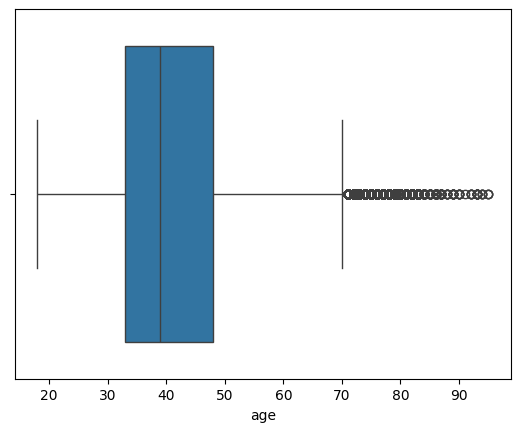

In [ ]:
sns.boxplot(x=train['age'])
plt.show()

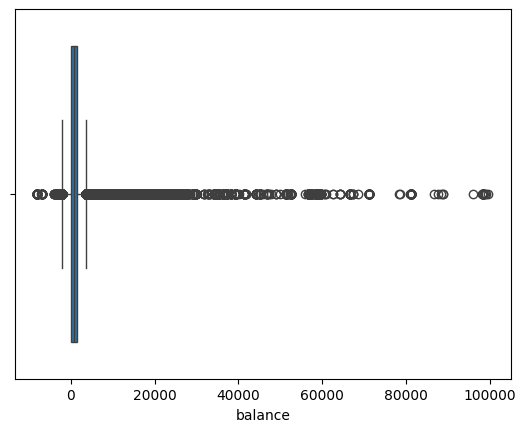

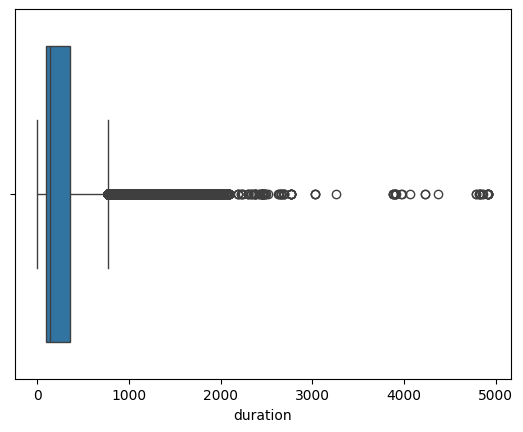

In [ ]:
sns.boxplot(x=train['age'])
plt.show()

sns.boxplot(x=train['balance'])
plt.show()

sns.boxplot(x=train['duration'])
plt.show()


In [ ]:
train.groupby('housing')['y'].count() #not showing

housing
no     338712
yes    411288
Name: y, dtype: int64

In [106]:
# Cap at 1st and 99th percentiles

def outlier_cleanse(df, col):
    low = df[col].quantile(0.01)
    high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=low, upper=high)
    
    return df


In [107]:
train_cleanse = train

for col in numeric_cols:
    outlier_cleanse(train_cleanse,col)

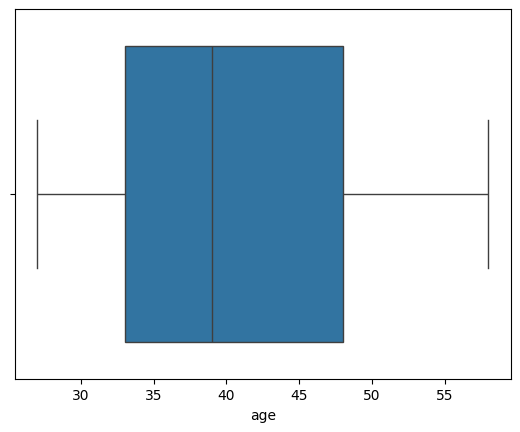

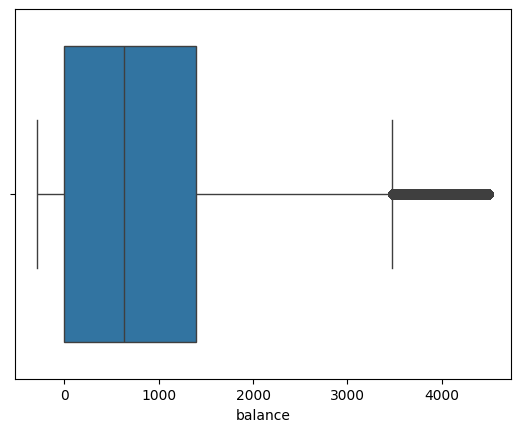

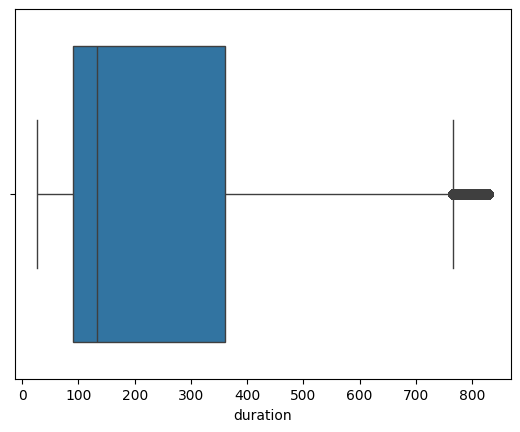

In [ ]:
sns.boxplot(x=train_cleanse['age'])
plt.show()

sns.boxplot(x=train_cleanse['balance'])
plt.show()

sns.boxplot(x=train_cleanse['duration'])
plt.show()


In [ ]:
train.groupby('education')['y'].count() #not showing

education
primary       99510
secondary    401683
tertiary     227508
unknown       21299
Name: y, dtype: int64

In [ ]:
train.groupby('month')['y'].count() #not showing

month
apr     41319
aug    128859
dec      2069
feb     37611
jan     18937
jul    110647
jun     93670
mar      5802
may    228411
nov     66062
oct      9204
sep      7409
Name: y, dtype: int64

In [108]:
## cleaned X and Y
X_cl = train_cleanse.drop(columns = ['y','id'])
Y_cl = train_cleanse['y']

In [109]:
pipeline_LR.fit(X_cl, Y_cl)
y_pred_cl = pipeline_LR.predict(kaggle_X)

# Create DataFrame from predictions and assign column name
kaggle_LR_cl = pd.DataFrame({"y": y_pred_all.flatten()})  

# Add the ID column from kaggle_test
kaggle_LR_cl["id"] = kaggle_X["id"].values

# Reorder columns to make 'id' the first column
kaggle_LR_cl = kaggle_LR_cl[["id", "y"]]

# kaggle_LR_all.to_csv("LR_submission.csv", index= False)

kaggle_output(kaggle_LR_cl, "LR_pred_clean.csv")


In [110]:

# def build_nn_model():
#     model = Sequential()
#     model.add(Dense(64, input_dim=len(numeric_cols) + preprocessor.transformers_[1][1].get_feature_names_out().shape[0], activation='relu'))  # Input dim will be handled automatically by scikeras
#     model.add(Dropout(0.3))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))  # Binary classification
#     model.compile(optimizer=Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model


In [119]:
#light gbm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
import lightgbm as lgb

# Load your dataset
df = train  # change this to your actual path
X = df.drop(columns=['y'])    # change 'target' to your target column name
y = df['y']

# Train-test split (stratify to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# # Identify feature types
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# # Preprocessing steps
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', 'passthrough')  # Use OneHotEncoder if needed
# ])

# preprocessor = ColumnTransformer(transformers=[
#     ('num', numeric_transformer, numeric_features),
#     ('cat', categorical_transformer, categorical_features)
# ])

# LightGBM Classifier with imbalance handling
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,  # Alternatively: scale_pos_weight if you want more control
    random_state=42,
    class_weight = 'balanced',
    classifier__num_leaves= 63,
    classifier__n_estimators= 200,
    classifier__max_depth= 7,
    classifier__learning_rate= 0.1,
    n_jobs=-1
)

# Full pipeline
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm_clf)
])


# Fit model
pipeline_lgbm.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline_lgbm.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> in

/Users/jadonfreed/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
              precision    recall  f1-score   support

           0       1.00      0.75      0.86    131902
           1       0.36      0.99      0.52     18098

    accuracy                           0.78    150000
   macro avg       0.68      0.87      0.69    150000
weighted avg       0.92      0.78      0.82    150000



In [120]:
y_pred_lgbm = pipeline_lgbm.predict(kaggle_X)

# Create DataFrame from predictions and assign column name
kaggle_LR_lgbm = pd.DataFrame({"y": y_pred_lgbm.flatten()})  

# Add the ID column from kaggle_test
kaggle_LR_lgbm["id"] = kaggle_X["id"].values

# Reorder columns to make 'id' the first column
kaggle_LR_lgbm = kaggle_LR_lgbm[["id", "y"]]

# kaggle_LR_all.to_csv("LR_submission.csv", index= False)

kaggle_output(kaggle_LR_lgbm, "lgbm_pred.csv")


/Users/jadonfreed/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth


[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> in

/Users/jadonfreed/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93    131902
           1       0.51      0.94      0.66     18098

    accuracy                           0.88    150000
   macro avg       0.75      0.91      0.80    150000
weighted avg       0.93      0.88      0.90    150000

